In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj,np.ndarray):
        size=obj.nbytes
    elif isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

def RLE_encode(img):
    og_shape = img.shape
    if len(img.shape) > 1:
        img = img.flatten()

    buffor = np.zeros(np.prod(img.shape)*2, dtype=int)
    repeats = 1
    buffor_index = 0
    img_index = 0
    while img_index < len(img) - 1:
        symbol = img[img_index]
        while(img[img_index] == img[img_index + 1]):
            repeats += 1
            img_index += 1
            if img_index + 1 == len(img):
                break


        img_index += 1

        buffor[buffor_index] = repeats
        buffor[buffor_index + 1] = symbol
        buffor_index += 2
        repeats = 1

    if img_index == len(img) - 1:
        buffor[buffor_index] = repeats
        buffor[buffor_index + 1] = img[img_index]
        buffor_index += 2

    new_buffor = buffor[:buffor_index]
    return new_buffor, og_shape

#tu też nie ma błędów

def RLE_decode(img_encoded, og_shape):
    #buffer o rozmiarze iloczynu og_shape, czyli tyle ile powinno być ponownie
    decoded_buffor = np.zeros(np.prod(og_shape), dtype=int)
    encoded_index = 0
    buffor_index = 0

    while(encoded_index < len(img_encoded) - 1):
        repeats = int(img_encoded[encoded_index])
        symbol = img_encoded[encoded_index + 1]

        decoded_buffor[buffor_index : buffor_index + repeats] = symbol
        encoded_index += 2
        buffor_index += repeats

    return decoded_buffor.reshape(og_shape)

In [ ]:

class ver1:
    Y=np.array([])
    Cb=np.array([])
    Cr=np.array([])
    ChromaRatio="4:4:4"
    QY=np.ones((8,8))
    QC=np.ones((8,8))
    shape=(0,0,3)
    Y_shape = None
    Cr_shape = None
    Cb_shape = None

def CompressBlock(block, Q):
    block -= 128
    dct_block = dct2(block)
    dct_block = np.round(dct_block/Q[:dct_block.shape[0], :dct_block.shape[1]]).astype(int)
    #print(dct_block.shape)
    zig_block = zigzag(dct_block)
    vector = zig_block.flatten()
    return vector


def DecompressBlock(vector, Q):
    zig_block = zigzag(vector)
    zig_block *= Q
    idct_block = idct2(zig_block)
    idct_block += 128
    return idct_block

QY_kwant = np.array([
        [16, 11, 10, 16, 24,  40,  51,  61],
        [12, 12, 14, 19, 26,  58,  60,  55],
        [14, 13, 16, 24, 40,  57,  69,  56],
        [14, 17, 22, 29, 51,  87,  80,  62],
        [18, 22, 37, 56, 68,  109, 103, 77],
        [24, 36, 55, 64, 81,  104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
        ])

QC_kwant = np.array([
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        ])

## podział na bloki
# L - warstwa kompresowana
# S - wektor wyjściowy
#dla chrominacji, bloki są dalej 8x8 ale mamy mniej informacji do przetworzenia,
def CompressLayer(L,Q):
    S=np.array([])
    for w in range(0,L.shape[0],8):
        for k in range(0,L.shape[1],8):
            block=L[w:(w+8),k:(k+8)]
            S=np.append(S, CompressBlock(block,Q))

    return S
## wyodrębnianie bloków z wektora
# L - warstwa o oczekiwanym rozmiarze
# S - długi wektor zawierający skompresowane dane
def DecompressLayer(S,shape, Q):
    L = np.zeros((shape[0], shape[1]))
    for idx,i in enumerate(range(0,S.shape[0],64)):
        vector=S[i:(i+64)]
        m=L.shape[1]/8
        k=int((idx%m)*8)
        w=int((idx//m)*8)
        L[w:(w+8),k:(k+8)]=DecompressBlock(vector,Q)

    return L

def dct2(a):
    return scipy.fftpack.dct(scipy.fftpack.dct(a.astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(a):
    return scipy.fftpack.idct(scipy.fftpack.idct(a.astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')

def chroma_subsampling(L, Ratio):
    if Ratio == "4:4:4":
        return L
    elif Ratio == "4:2:2":
        return L[:, ::2]
    else:
        return L

def chroma_upsampling(L, Ratio):
    if Ratio == "4:4:4":
        return L
    elif Ratio == "4:2:2":
        upsampled = np.zeros((L.shape[0], L.shape[1] * 2), dtype=L.dtype)
        upsampled[:, ::2] = L
        upsampled[:, 1::2] = L  # powielaj te same wartości na przemian
        return upsampled
    else:
        return L

#kłopotliwa funkcja
def zigzag(A):
    template = np.array([
        [0,  1,  5,  6, 14, 15, 27, 28],
        [2,  4,  7, 13, 16, 26, 29, 42],
        [3,  8, 12, 17, 25, 30, 41, 43],
        [9, 11, 18, 24, 31, 40, 44, 53],
        [10,19, 23, 32, 39, 45, 52, 54],
        [20,22, 33, 38, 46, 51, 55, 60],
        [21,34, 37, 47, 50, 56, 59, 61],
        [35,36, 48, 49, 57, 58, 62, 63],
    ])

    if len(A.shape) == 1:
        # Dekodowanie z wektora na blok 8×8
        B = np.zeros((8, 8))
        for r in range(8):
            for c in range(8):
                B[r, c] = A[template[r, c]]
        return B[:8, :8]  # zawsze zwracamy cały blok (użytkownik może sam przyciąć)
    else:
        #dodaj padding
        h, w = A.shape
        P = np.zeros((8, 8))
        P[:h, :w] = A
        B = np.zeros((64,))
        for r in range(8):
            for c in range(8):
                B[template[r, c]] = P[r, c]
        return B

def CompressJPEG(RGB,Ratio="4:4:4",QY=np.ones((8,8)),QC=np.ones((8,8))):
    # RGB -> YCrCb
    YCrCb=cv2.cvtColor(RGB,cv2.COLOR_RGB2YCrCb).astype(int)
    JPEG= ver1()

    #PODZIAŁ NA WARSTWY
    JPEG.Y = YCrCb[:,:,0]
    JPEG.Cr = YCrCb[:,:,1]
    JPEG.Cb = YCrCb[:,:,2]
    JPEG.ChromaRatio=Ratio
    JPEG.QY=QY
    JPEG.QC=QC
    JPEG.shape = YCrCb.shape

    #print("before subsampling:", JPEG.Cr.shape)
    #print("before subsampling:",JPEG.Cb.shape)
    #CHROMA_SUB
    JPEG.Cr = chroma_subsampling(JPEG.Cr, JPEG.ChromaRatio)
    JPEG.Cb = chroma_subsampling(JPEG.Cb, JPEG.ChromaRatio)
    #print("after subsampling:", JPEG.Cr.shape)
    #print("after subsampling:", JPEG.Cb.shape)
    #COMPRESS -> DCT, ZIGZAG I KWANTYZACJA W COMPRESS_BLOCK
    JPEG.Y=CompressLayer(JPEG.Y,JPEG.QY)
    JPEG.Cr=CompressLayer(JPEG.Cr,JPEG.QC)
    JPEG.Cb=CompressLayer(JPEG.Cb,JPEG.QC)

    #RLE
    JPEG.Y, JPEG.Y_shape = RLE_encode(JPEG.Y)
    JPEG.Cr, JPEG.Cr_shape = RLE_encode(JPEG.Cr)
    JPEG.Cb, JPEG.Cb_shape = RLE_encode(JPEG.Cb)
    return JPEG


def DecompressJPEG(JPEG):
    #RLE WSTECZ
    JPEG.Y = RLE_decode(JPEG.Y, JPEG.Y_shape)
    JPEG.Cr = RLE_decode(JPEG.Cr, JPEG.Cr_shape)
    JPEG.Cb = RLE_decode(JPEG.Cb, JPEG.Cb_shape)

    #DECOMPRESS -> IDCT ETC.
    #print("before deco:", JPEG.Cr.shape)
    #print("before deco:", JPEG.Cb.shape)
    JPEG.Y=DecompressLayer(JPEG.Y, JPEG.shape, JPEG.QY)
    if JPEG.ChromaRatio == "4:2:2":
        cr_shape = (JPEG.shape[0], JPEG.shape[1] // 2)
        JPEG.Cr=DecompressLayer(JPEG.Cr, cr_shape, JPEG.QC)
        JPEG.Cb=DecompressLayer(JPEG.Cb, cr_shape, JPEG.QC)
    else:
        JPEG.Cr=DecompressLayer(JPEG.Cr, JPEG.shape, JPEG.QC)
        JPEG.Cb=DecompressLayer(JPEG.Cb, JPEG.shape, JPEG.QC)
    #print("after deco:", JPEG.Cr.shape)
    #print("after deco:", JPEG.Cb.shape)

    #CHROMA_RESAMPLE
    JPEG.Cr = chroma_upsampling(JPEG.Cr, JPEG.ChromaRatio)
    JPEG.Cb = chroma_upsampling(JPEG.Cb, JPEG.ChromaRatio)
    #ZŁÓŻ OBRAZ
    YCrCb=np.dstack([JPEG.Y,JPEG.Cr,JPEG.Cb]).clip(0,255).astype(np.uint8)
    # YCrCb -> RGB
    RGB=cv2.cvtColor(YCrCb.astype(np.uint8),cv2.COLOR_YCrCb2RGB)
    return RGB



def JPEG_ALGO(img, fragments=[[(0, 128), (0, 128)]], save_path="jpeg_fragments_comparison.png"):
    # Kombinacje (Ratio, QY, QC, opis)
    variants = [
        ("4:4:4", np.ones((8, 8)), np.ones((8, 8)), "4:4:4, Q=ones"),
        ("4:2:2", np.ones((8, 8)), np.ones((8, 8)), "4:2:2, Q=ones"),
        ("4:4:4", QY_kwant, QC_kwant, "4:4:4, Q=JPEG std"),
        ("4:2:2", QY_kwant, QC_kwant, "4:2:2, Q=JPEG std"),
    ]

    fig, axs = plt.subplots(len(fragments), 1 + len(variants), figsize=(16, 4 * len(fragments)))
    if len(fragments) == 1:
        axs = [axs]

    for row_idx, fragment in enumerate(fragments):
        (r_start, r_end), (c_start, c_end) = fragment
        original_fragment = img[r_start:r_end, c_start:c_end]
        axs[row_idx][0].imshow(original_fragment)
        axs[row_idx][0].set_title("Original")
        axs[row_idx][0].axis('off')

        for idx, (ratio, QY, QC, label) in enumerate(variants):
            compressed = CompressJPEG(img, Ratio=ratio, QY=QY, QC=QC)
            decompressed = DecompressJPEG(compressed)
            decompressed_fragment = decompressed[r_start:r_end, c_start:c_end]
            print(label, " - ", (get_size(img)/get_size(compressed)) * 100)
            axs[row_idx][idx + 1].imshow(decompressed_fragment)
            axs[row_idx][idx + 1].set_title(label)
            axs[row_idx][idx + 1].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


4:4:4, Q=ones  -  12.49904629672788
4:2:2, Q=ones  -  12.49904955144036
4:4:4, Q=JPEG std  -  12.499052806154534
4:2:2, Q=JPEG std  -  12.499056060870403


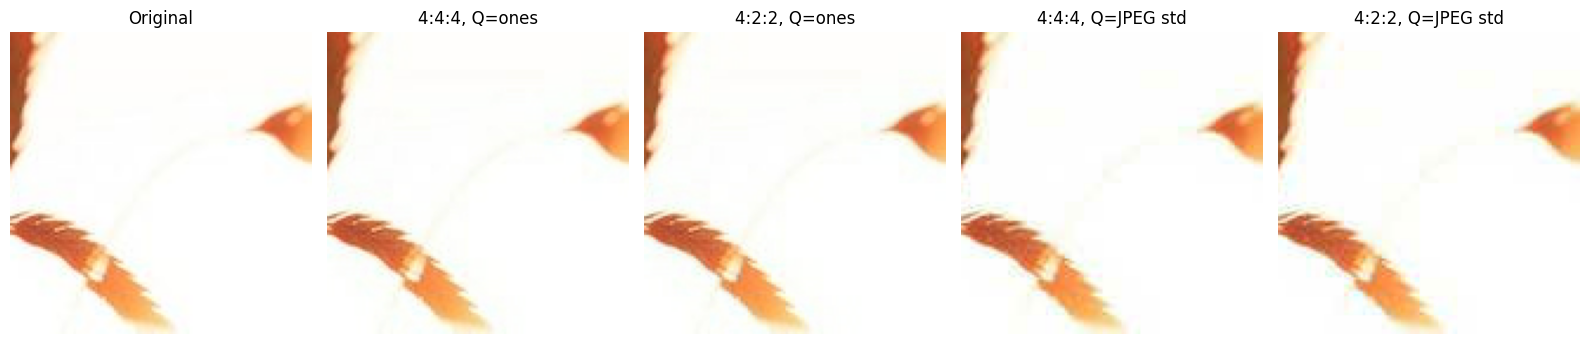

4:4:4, Q=ones  -  12.499059315587967
4:2:2, Q=ones  -  12.499062570307228
4:4:4, Q=JPEG std  -  12.49906582502818
4:2:2, Q=JPEG std  -  12.49906907975083


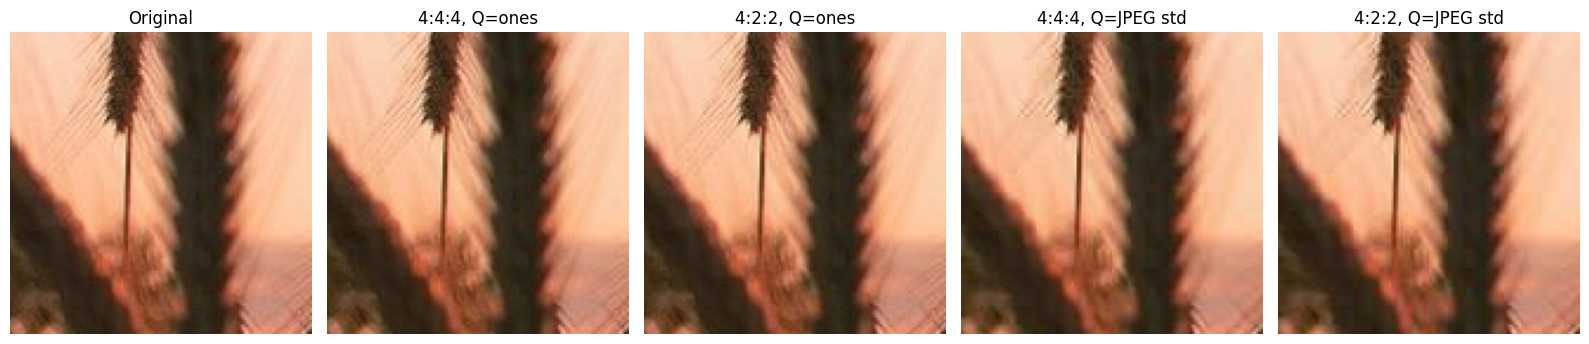

4:4:4, Q=ones  -  12.499072334475175
4:2:2, Q=ones  -  12.499075589201215
4:4:4, Q=JPEG std  -  12.49907884392895
4:2:2, Q=JPEG std  -  12.49908209865838


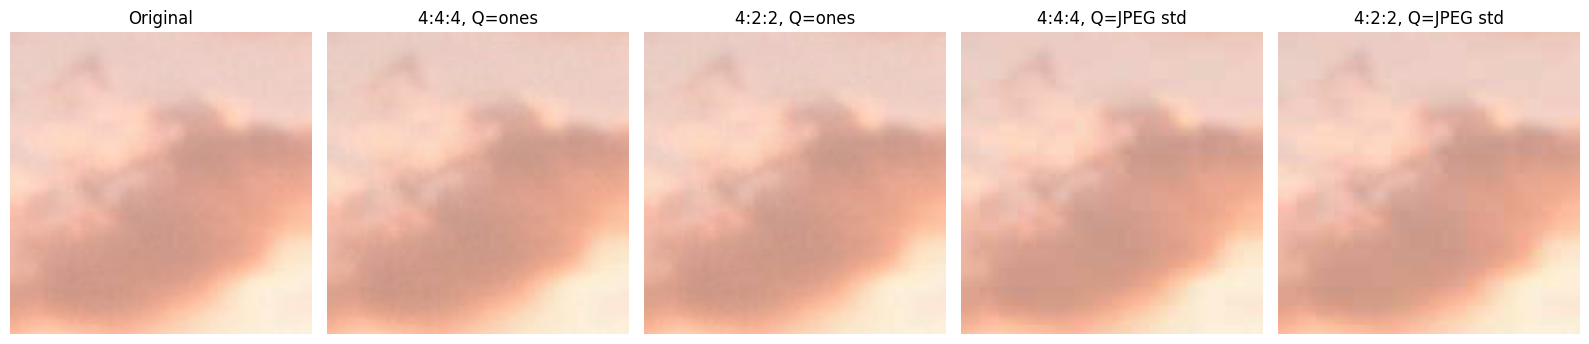

In [ ]:
RGB = plt.imread('/content/sunset.jpg')
JPEG_ALGO(RGB, fragments=[[(400, 528), (1300, 1428)]], save_path="1.jpg")
JPEG_ALGO(RGB, fragments=[[(500, 628), (400, 528)]], save_path="2.jpg")
JPEG_ALGO(RGB, fragments=[[(100, 228), (800, 928)]], save_path="3.jpg")

[181 163 161]


KeyboardInterrupt: 

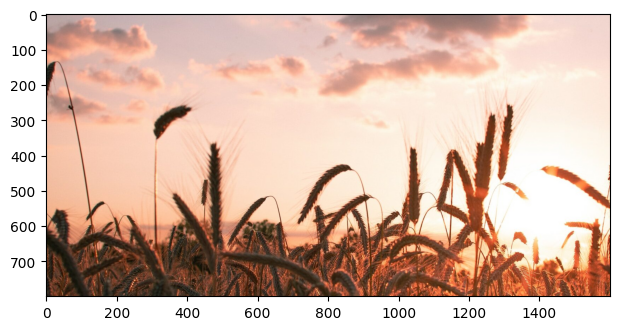

In [ ]:
RGB = plt.imread('/content/sunset.jpg')
fig = plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(RGB)
print(RGB[0,0,:])
compressed = CompressJPEG(RGB, Ratio="4:4:4",QC=QC_kwant, QY=QY_kwant)
new_RGB = DecompressJPEG(compressed)
print(new_RGB[0,0,:])
plt.subplot(1, 2, 2)
plt.imshow(new_RGB)